In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
%matplotlib inline

In [2]:
def fetch_dataset(path):
    images = []
    labels = []
    for dir1 in os.listdir(path):
        for file in os.listdir(os.path.join(path,dir1)):
            image_path = os.path.join(path,dir1,file)
            with Image.open(image_path).convert('L') as img:
                arr = np.array(img.getdata()).reshape(256, 256, 1) / 255
                images.append(arr)
                labels.append(dir1)
    
    unique_labels = {k: v for v,k in enumerate(np.unique(labels))}
    numeric_labels = [unique_labels[labels[i]] for i in range(len(labels))]
    #print(numeric_labels)
    return np.array(images),numeric_labels


In [3]:
train_path = os.path.join("data","train")
val_path = os.path.join("data","val")
test_path = os.path.join("data","test")


x_train,y_train = fetch_dataset(train_path)
x_val,y_val = fetch_dataset(val_path)
#x_test,y_test = fetch_dataset(test_path)

In [4]:
y_train_classes = y_train
y_val_classes = y_val
y_train = tf.keras.utils.to_categorical(y_train_classes, 4)
y_val = tf.keras.utils.to_categorical(y_val_classes, 4)

In [5]:
classes = ["COVID", "HEALTHY", "PNEUMONIA_BAC", "PNEUMONIA_VIR"]

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
from shutil import rmtree
if os.path.exists("logs"):
    rmtree("logs")

In [8]:
# tensorboard integration
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# early stopping values
callback_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_recall_m",
    min_delta=0.002,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

In [9]:
# sample weights
#print(y_train_classes)
print(len(y_train_classes))

s_weights = []
for i in y_train_classes:
    if y_train_classes[i] == 0:
        s_weights.append(1)
    if y_train_classes[i] == 1:
        s_weights.append(.7)
    if y_train_classes[i] == 2:
        s_weights.append(1)
    if y_train_classes[i] == 3:
        s_weights.append(1)



        
s_weights = np.array(s_weights)
s_weights.shape
print(s_weights)

#class weights
c_weights = {
   0: .40, 
   1: .1, 
   2: .25, 
   3: .25
}

15558
[1 1 1 ... 1 1 1]


### Model declaration

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

data_dims = (256, 256, 1)

model_1 = Sequential([
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same", input_shape=data_dims),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.30),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),
    Flatten(),
    Dense(16, activation="sigmoid"),
    Dropout(0.25),
    Dense(4, activation="softmax")
])

model_1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "categorical_crossentropy", f1_m, precision_m, recall_m])

In [12]:
model = model_1
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 20)      3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 20)        3620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0

### Model Testing

In [13]:
#print(X_train.shape)

model.fit(
    x_train.reshape(-1, 256, 256, 1), y_train,
    epochs=20,
    batch_size=64,
    #shuffle=True,
    #class_weight=c_weights,
    sample_weight=s_weights,
    validation_data=(x_val.reshape(-1, 256, 256, 1), y_val),
    callbacks=[tensorboard_callback, callback_stop],
    #callbacks=[tensorboard_callback],
    verbose=1
    )

Epoch 1/20
  1/244 [..............................] - ETA: 0s - loss: 1.3463 - accuracy: 0.4219 - categorical_crossentropy: 1.3463 - f1_m: 0.2979 - precision_m: 0.4667 - recall_m: 0.2188WARNING:tensorflow:From D:\Programme\Anaconda\envs\machine-learning2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
244/244 [==============================] - 251s 1s/step - loss: 0.8116 - accuracy: 0.6702 - categorical_crossentropy: 0.8116 - f1_m: 0.5974 - precision_m: 0.7932 - recall_m: 0.4878 - val_loss: 0.5985 - val_accuracy: 0.7814 - val_categorical_crossentropy: 0.5985 - val_f1_m: 0.7180 - val_precision_m: 0.8261 - val_recall_m: 0.6448
Epoch 2/20
244/244 [==============================] - 250s 1s/step - loss: 0.5433 - accuracy: 0.7993 - categorical_crossentropy: 0.5433 - f1_m: 0.7746 - precision_m: 0.8472 - recall_

In [16]:
y_val_pred = model.predict(x_val.reshape(-1, 256, 256, 1))
y_val_pred_classes = tf.argmax(y_val_pred, axis=1)

### Confusion Matrix

In [63]:
import pandas as pd
import seaborn

def plot_confusion_matrix(cm):
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    figure = plt.figure(figsize=(8, 8))
    seaborn.heatmap(cm_df, annot=True, fmt="g", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    figure.savefig('covid-xray-cm_model.svg', format='svg')
    figure.savefig('covid-xray-cm_model.png', format='png')
    return figure


cm = tf.math.confusion_matrix(y_val_classes, y_val_pred_classes).numpy()
cm_norm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

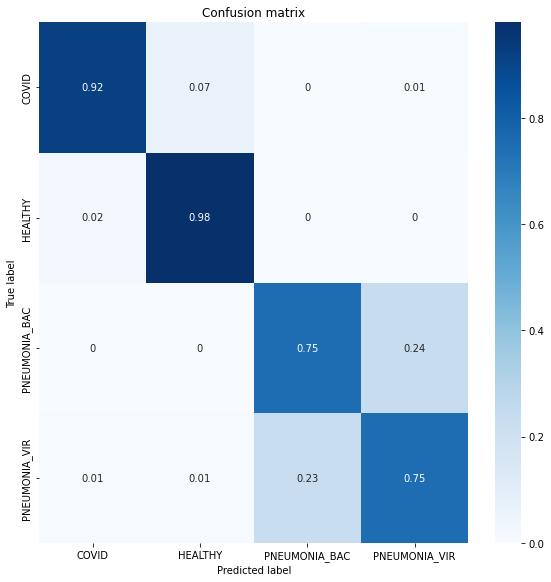

In [64]:
figure = plot_confusion_matrix(cm_norm)

### PR Curve (Average)

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.97')

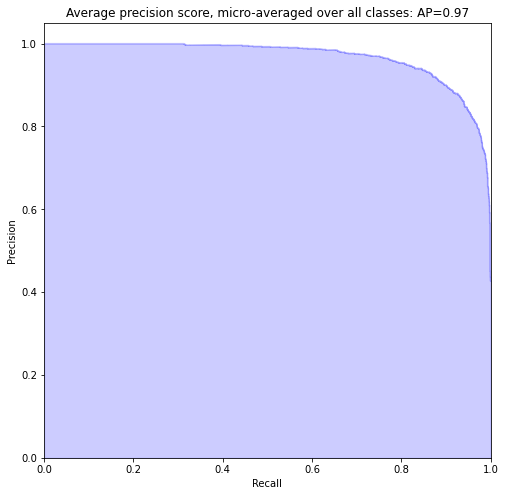

In [65]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from inspect import signature

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i], y_val_pred[:, i])
    average_precision[i] = average_precision_score(y_val[:, i], y_val_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val.ravel(), y_val_pred.ravel())
average_precision["micro"] = average_precision_score(y_val, y_val_pred, average="micro")

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

fig = plt.figure(figsize=(8, 8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

In [66]:
plt.show()

fig.savefig('covid-xray-precision-recall.svg', format='svg')

### PR Curve

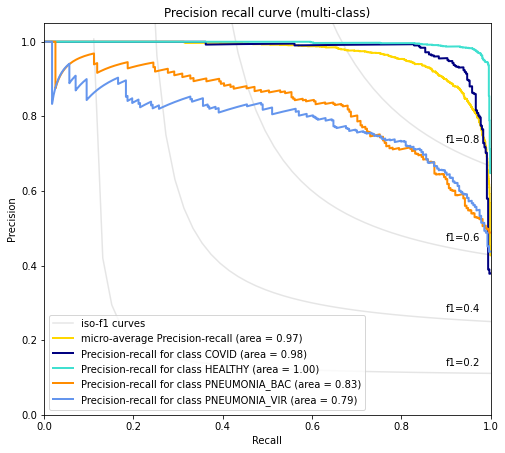

In [49]:
from itertools import cycle

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(classes[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.20)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision recall curve (multi-class)')
plt.legend(lines, labels, prop=dict(size=10), loc='lower left')

In [55]:
plt.show()

fig.savefig('covid-xray-precision-recall-extended.svg', format='svg')
#fig.savefig('covid-xray-precision-recall-extended.png', format='png')

### ROC Curve

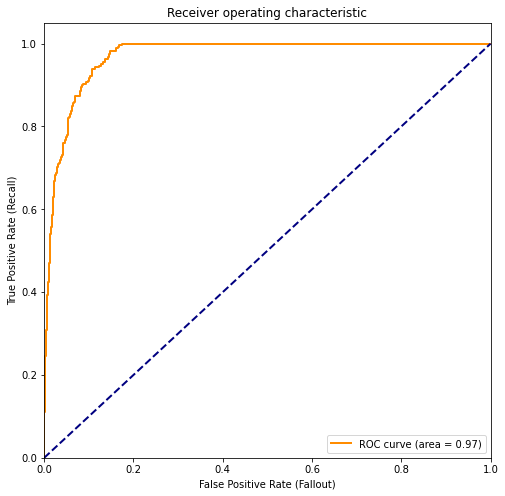

In [62]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig = plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fallout)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

fig.savefig('covid-xray-roc.svg', format='svg')

# Keras Tuner part

In [70]:
def build_model_1():
    data_dims = (256, 256, 1)

    model = Sequential([
        Conv2D(
            20, 
            kernel_size=(3, 3), activation="relu", padding="same", input_shape=data_dims),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.30),
        Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.30),
        Flatten(),
        Dense(16, activation="sigmoid"),
        Dropout(0.25),
        Dense(4, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", "categorical_crossentropy", f1_m, precision_m, recall_m])
    return model

### Iteration 1

Amount of convolutions/feature maps per layer

In [1]:
def build_model_1():
    data_dims = (256, 256, 1)

    model = Sequential()
    model.add(Conv2D(20,kernel_size=(3, 3), activation="relu", padding="same", input_shape=data_dims))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.30))
    model.add(Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.30))
    model.add(Flatten())
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", "categorical_crossentropy", f1_m, precision_m, recall_m])
    return model

In [2]:
model_2 = build_model_1()
model_2.fit(
    x_train.reshape(-1, 256, 256, 1), y_train,
    epochs=5,
    batch_size=512,
    validation_data=(x_val.reshape(-1, 256, 256, 1), y_val),
    verbose=1
    )

NameError: name 'Sequential' is not defined